In [1]:
# change working directory to the root of the project
import os
os.chdir('..')

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import pyprotoevo

sim_name = 'gaia-seadra-voluptas'

In [4]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [5]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

In [87]:
genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 20 == 0
}

In [6]:
all_stats = set(stat for time_stamp in stats for stat in stats[time_stamp]['stats'])

In [8]:
black_list = ['Node', 'Organelle', 'Log', 'Molecule']
basic_stats = [
    stat for stat in all_stats
    if all(x not in stat for x in black_list)
]
print('\n'.join(basic_stats))

Construction Mass Limit Max
Multicell Structure Size Max
Protozoa
Generation Max
Health Max
Plant to Digest Mean
Meat Digestion Rate Max
Herbivore Factor Min
Num Mutations Min
Plants
Mean Mutation Chance Max
Died from cytokinesis
Age Mean
Died from spike damage
Plant to Digest Max
Being Engulfed Min
GRN Size Min
Death Rate Mean
Age Min
Meat Created
Num Cell Bindings Count
Num Mutations Mean
Died from exceeding environment capacity
Split Radius Max
Growth Rate Min
Mean Mutation Chance Min
Num Spikes Min
Energy Limit Mean
Age Max
Num Cell Bindings Max
Size Mean
Plant Digestion Rate Mean
Joints
Died from the void
Available Energy Min
Total Mass Min
Num Engulfed Min
Died from running out of health
Construction Mass Limit Min
Num Engulfed Max
Num Engulfed Mean
Died from being eaten
Speed Mean
GRN Depth Min
Fixtures
Crossover Events
Meat to Digest Max
Num Spikes Max
Speed Max
Construction Mass Mean
Died from suffocation
GRN Size Max
Death Rate Max
GRN Depth Max
Split Radius Min
Bodies
Num Ce

In [18]:
stat_types = {
    stat: record['unit']['units']
    for time_stamp in stats.keys()
    for stat, record in stats[time_stamp]['stats'].items()
    if record['unit'] is not None
}

In [19]:
def unit_to_string(unit: dict) -> str:
    '''
    Convert a unit dictionary to a string.
    For instance, {'MASS': 1, 'TIME': -1} becomes 'µg/s'.
    Possible base units are:
    - MASS: converted to micrograms (1e-6)
    - DISTANCE: converted to micrometers (1e-6)
    - TIME: converted to seconds (1)
    - ENERGY: converted to joules (1)
    - COUNT: converted to number (1)
    - ANGLE: converted to radians (1)
    - PERCENTAGE: converted to percentage (1)
    '''
    units = {
        'MASS': 'µg',
        'DISTANCE': 'µm',
        'TIME': 's',
        'ENERGY': 'J',
        'COUNT': '',
        'ANGLE': 'rad',
        'PERCENTAGE': '%'
    }
    return ''.join([
        units[key] + ('' if val == 1 else '^{' + str(val) + '}')
        for key, val in unit.items()
    ])

In [20]:
stat_type_strs = {
    stat: unit_to_string(unit)
    for stat, unit in stat_types.items()
}

In [21]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']

In [22]:
from datetime import datetime

In [23]:
generation_df = pd.DataFrame([
    {
        'Time': datetime(*map(int, time_stamp.split('-'))),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in stats.items()
]);
generation_df['Wall Time'] = generation_df['Time'] - generation_df['Time'].min()
generation_df['Next Time Stamp'] = generation_df['Time Stamp'].shift(-1)
generation_df.head()

,Time,Time Stamp,Generation,Wall Time,Next Time Stamp
0,2023-03-05 16:52:35,2023-03-05-16-52-35,1,0 days 00:00:00,2023-03-05-16-59-20
1,2023-03-05 16:59:20,2023-03-05-16-59-20,2,0 days 00:06:45,2023-03-05-17-07-11
2,2023-03-05 17:07:11,2023-03-05-17-07-11,3,0 days 00:14:36,2023-03-05-17-15-02
3,2023-03-05 17:15:02,2023-03-05-17-15-02,3,0 days 00:22:27,2023-03-05-17-23-10
4,2023-03-05 17:23:10,2023-03-05-17-23-10,3,0 days 00:30:35,2023-03-05-17-31-25


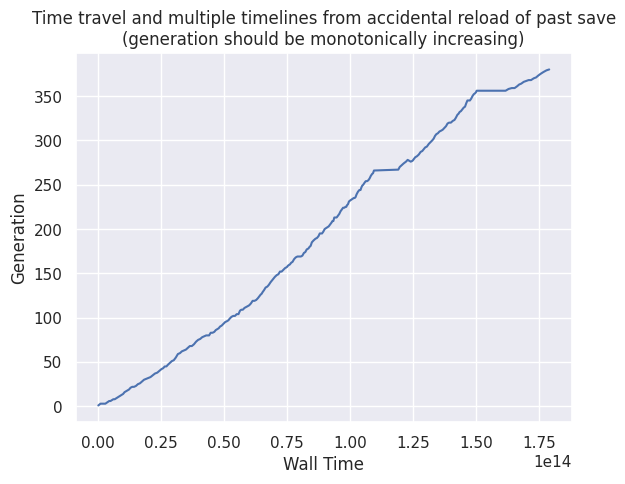

In [24]:
plt.title('Time travel and multiple timelines from accidental reload of past save\n(generation should be monotonically increasing)')
sns.lineplot(data=generation_df, x='Wall Time', y='Generation');

In [25]:
generation_df = generation_df.sort_values('Time Stamp')
records = generation_df.to_records()


def are_all_future_records_of_higher_generation(record):
    return all(
        record['Generation'] < records[i]['Generation']
        for i in range(record['index'] + 1, len(records))
    )


cleaned_stats = {
    (time_stamp := record['Time Stamp']) : stats[time_stamp]
    for record in records
    if are_all_future_records_of_higher_generation(record)
}

In [26]:
def get_datetime(time_stamp: str) -> datetime:
    return datetime(*map(int, time_stamp.split('-')))

In [27]:
generation_df_cleaned = pd.DataFrame([
    {
        'Time': get_datetime(time_stamp),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in cleaned_stats.items()
]);
generation_df_cleaned['Wall Time'] = generation_df_cleaned['Time'] - generation_df_cleaned['Time'].min()

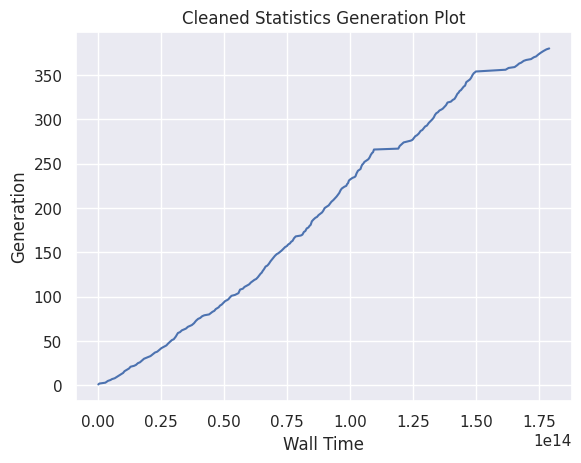

In [28]:
plt.title('Cleaned Statistics Generation Plot')
sns.lineplot(data=generation_df_cleaned, x='Wall Time', y='Generation');

In [29]:
stats = cleaned_stats

In [30]:
stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])

import re

stat_names = {
    match.group(1) for stat in stats_df.columns 
    if (match := re.match(r'(.*) [Mean|Max|Min|Count]', stat))
    and 'Died' not in stat
}
print('\n'.join(stat_names))

# for stat in stats:
#     stats_df[stats_df[stat + 'Min']]

# # stats_df.fillna(0, inplace=True)
stats_df.replace(to_replace='NaN', value=np.nan, inplace=True)
stats_df.head()

Construction Mass
Num Engulfed
Meat Digestion Rate
Growth Rate
Num Mutations
Multicell Structure Size
Total Mass
Plant to Digest
Being Engulfed
Size
Generation
Age
Health
Repair Rate
Speed
Protozoa
Num Spikes
Meat
Has Mated
Meat to Digest
Death Rate
Construction Mass Limit
Plants
Energy Limit
Plant Digestion Rate
Mean Mutation Chance
GRN Size
Split Radius
Num Cell Bindings
GRN Depth
Available Energy
Herbivore Factor


,Protozoa,Plants,Age Mean,Death Rate Mean,Num Mutations Mean,Died from exceeding environment capacity,Energy Limit Mean,Size Mean,Plant Digestion Rate Mean,Joints,...,Plant to Digest Min,Being Engulfed Max,Num Mutations Max,Construction Mass Max,Construction Mass Min,Meat Digestion Rate Min,Meat to Digest Min,Plant Digestion Rate Min,Total Mass Max,Died from being healed to death?...
0,300,1548,0.000000,0.000000,1.190000,452.0,201.341741,0.060403,1.282665,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,151,4000,19.546707,4.069189,1.264901,6834.0,169.549560,0.050865,1.284970,2711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39,3994,21.353868,4.936097,3.205128,21660.0,2056.707019,0.061701,1.396902,3183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,3998,20.862849,4.991800,4.152542,22608.0,2079.916756,0.062398,1.371834,3227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,3985,21.643576,5.151955,5.474576,23449.0,2146.648119,0.064399,1.414845,3276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
attachment_types = {
    match.group(2) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
attachment_types

{'Binding', 'Flagellum', 'Phagocytic Receptor', 'Photoreceptor', 'Spike'}

In [46]:
node_prefixes = {
    match.group(1) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
node_prefixes

{'Node 0',
 'Node 1',
 'Node 2',
 'Node 3',
 'Node 4',
 'Node 5',
 'Node 6',
 'Node 7'}

In [74]:
node_black_list = [
    'Organelle', 'Log', 'Molecule'
]

# node_stats = [
#     stat for stat in all_stats
#     if 'Node 0' in stat and 
node_stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in all_stats
        if 'Construction Progress Mean' in stat and stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])
node_stats_df.fillna(0, inplace=True)
node_stats_df.head()

,Node 1: Construction Progress Mean,Node 1: Binding Construction Progress Mean,Node 0: Construction Progress Mean,Node 2: Construction Progress Mean,Node 0: Spike Construction Progress Mean,Node 1: Flagellum Construction Progress Mean,Node 0: Photoreceptor Construction Progress Mean,Node 0: Phagocytic Receptor Construction Progress Mean,Node 1: Spike Construction Progress Mean,Node 2: Photoreceptor Construction Progress Mean,...,Node 6: Photoreceptor Construction Progress Mean,Node 6: Binding Construction Progress Mean,Node 6: Phagocytic Receptor Construction Progress Mean,Node 4: Flagellum Construction Progress Mean,Node 6: Flagellum Construction Progress Mean,Node 6: Spike Construction Progress Mean,Node 7: Construction Progress Mean,Node 7: Spike Construction Progress Mean,Node 7: Phagocytic Receptor Construction Progress Mean,Node 7: Photoreceptor Construction Progress Mean
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64.422232,0.013738,82.640038,75.594070,0.018911,0.057868,0.074922,0.015127,0.042457,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,80.053906,0.001193,47.728393,52.898235,0.015568,0.000000,0.000000,0.000000,0.000000,0.047734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.437218,0.006088,60.643280,57.908858,0.015568,0.000000,0.000000,0.000082,0.011825,0.047734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.720906,0.002342,47.952303,55.698771,0.015568,0.000000,0.060519,0.000076,0.012766,0.033548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
records = node_stats_df.to_dict('records')

In [76]:
record = records[0]

In [77]:
def get_construction_progress(record, node, attachment_type):
    return record[f'{node}: {attachment_type} Construction Progress Mean']

for node_suffix in node_prefixes:
    for attachment_type in attachment_types:
        node_stat = f'{node_suffix}: {attachment_type} Construction Progress Mean'
        
        if node_stat in record:
            print(node_stat, record[node_stat])

Node 1: Binding Construction Progress Mean 0.0
Node 1: Photoreceptor Construction Progress Mean 0.0
Node 1: Flagellum Construction Progress Mean 0.0
Node 1: Spike Construction Progress Mean 0.0
Node 1: Phagocytic Receptor Construction Progress Mean 0.0
Node 6: Binding Construction Progress Mean 0.0
Node 6: Photoreceptor Construction Progress Mean 0.0
Node 6: Flagellum Construction Progress Mean 0.0
Node 6: Spike Construction Progress Mean 0.0
Node 6: Phagocytic Receptor Construction Progress Mean 0.0
Node 5: Binding Construction Progress Mean 0.0
Node 5: Photoreceptor Construction Progress Mean 0.0
Node 5: Flagellum Construction Progress Mean 0.0
Node 5: Spike Construction Progress Mean 0.0
Node 5: Phagocytic Receptor Construction Progress Mean 0.0
Node 2: Binding Construction Progress Mean 0.0
Node 2: Photoreceptor Construction Progress Mean 0.0
Node 2: Flagellum Construction Progress Mean 0.0
Node 2: Spike Construction Progress Mean 0.0
Node 2: Phagocytic Receptor Construction Progre

In [43]:

attachment_types

{'Binding', 'Flagellum', 'Phagocytic Receptor', 'Photoreceptor', 'Spike'}

In [ ]:
stat, *_ = stat_names

In [ ]:
# is_na = pd.isna(stats_df[stat + ' Min'])
# stats_df[stat + ' Min'][is_na] = stats_df[stat + ' Mean'][is_na]

<AxesSubplot: >

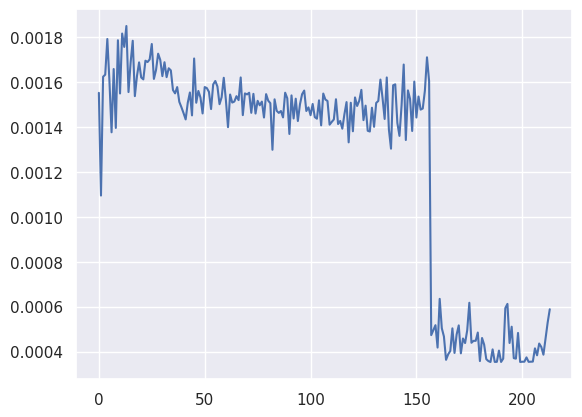

In [73]:
stats_df[stat + ' Min'].plot()

<AxesSubplot: xlabel='Max Protozoa Generation', ylabel='Protozoa'>

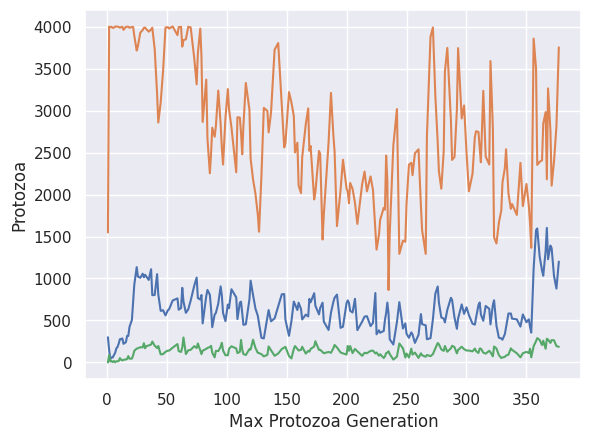

In [ ]:
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Protozoa')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Plants')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Meat Pellets')

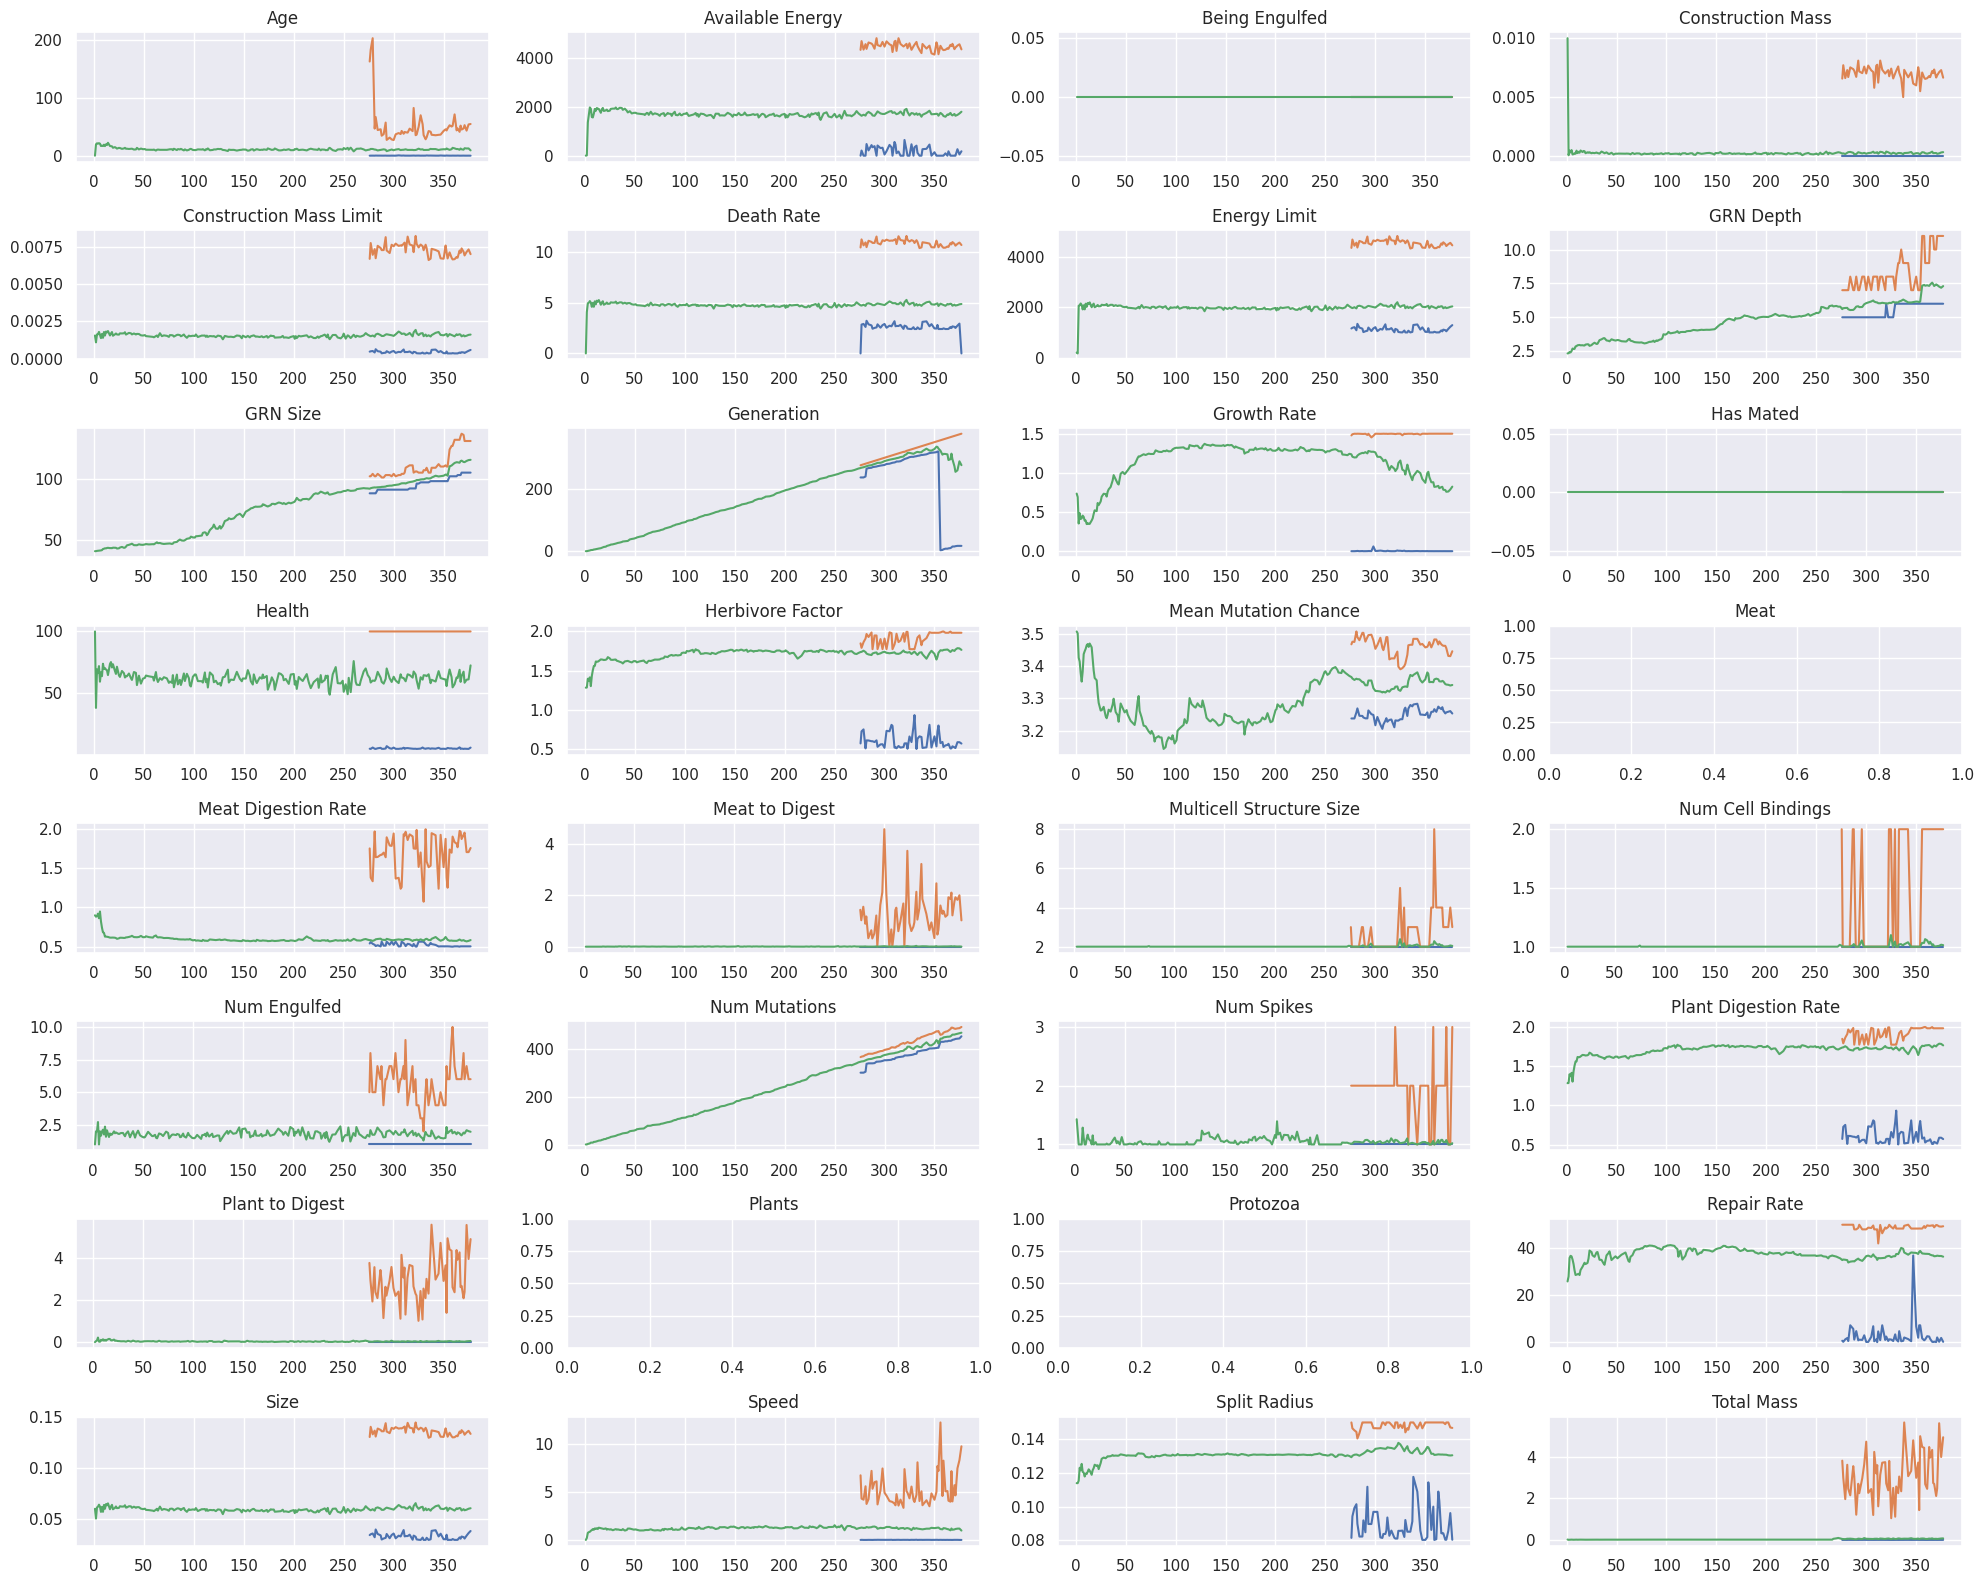

In [97]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
rows = int(np.ceil(len(stat_names) / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stat_names)):
    if stat is not None:
        for stat_type in ['Min', 'Max', 'Mean']: 
            variable = f'{stat} {stat_type}'
            if variable in stats_df.columns:
                sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
        ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

In [98]:
for stat in stat_names:
    if stat + ' Count' in stats_df.columns:
        stats_df[stat + ' Frequency'] = stats_df[stat + ' Count'] / stats_df['Protozoa']

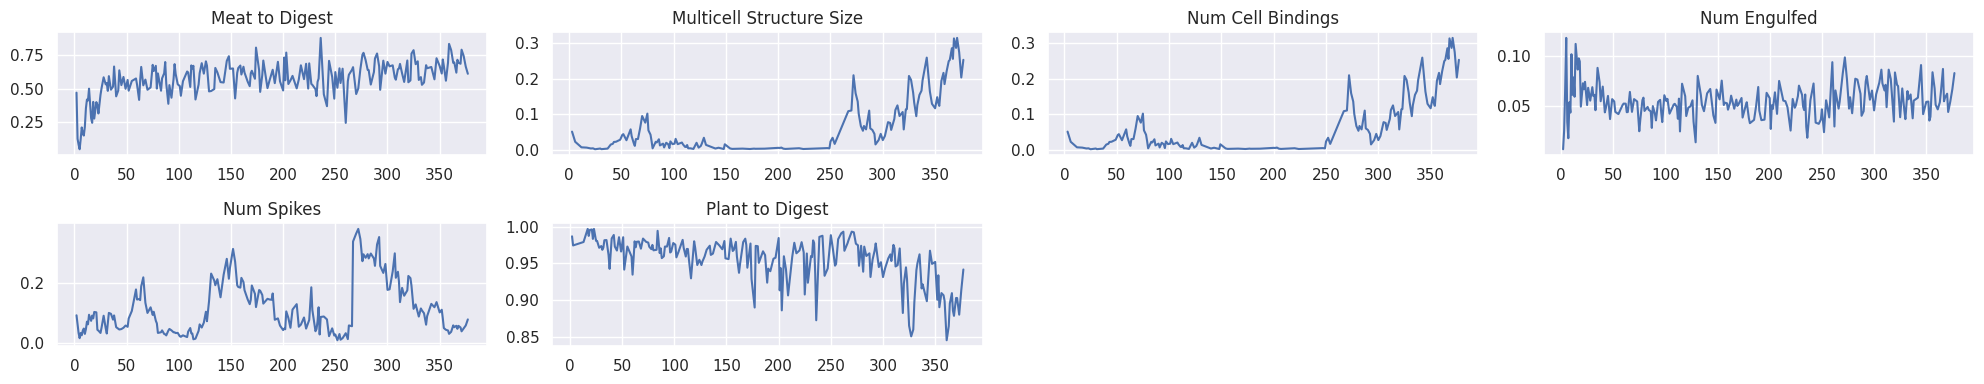

In [103]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
stats_with_counts = [stat for stat in stat_names if stat + ' Count' in stats_df.columns]
n_plots = len(stats_with_counts)
rows = int(np.ceil(n_plots / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stats_with_counts)):
    if stat is not None:
        variable = f'{stat} Frequency'
        if variable in stats_df.columns:
            sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
            ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

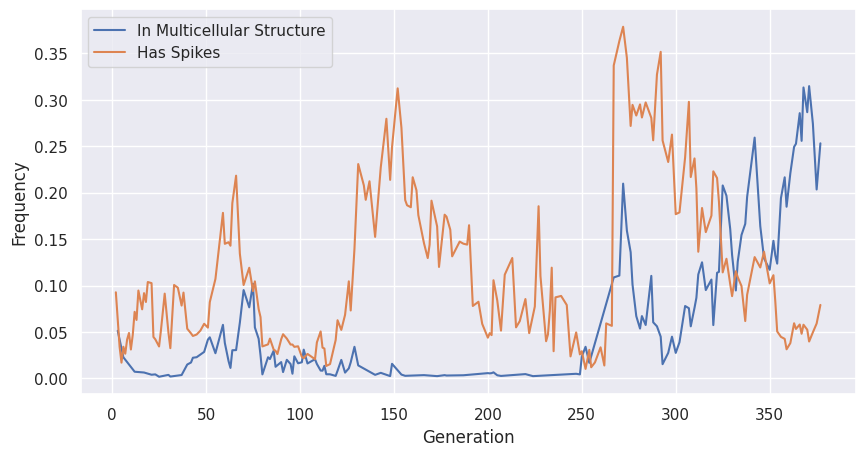

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))

labels_map = {
    'Multicell Structure Size': 'In Multicellular Structure',
    'Num Spikes': 'Has Spikes'
}

for stat in ['Multicell Structure Size', 'Num Spikes']:
    sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=f'{stat} Frequency', ax=ax, label=labels_map[stat])

ax.set_ylabel('Frequency')
ax.set_xlabel('Generation')

plt.show()

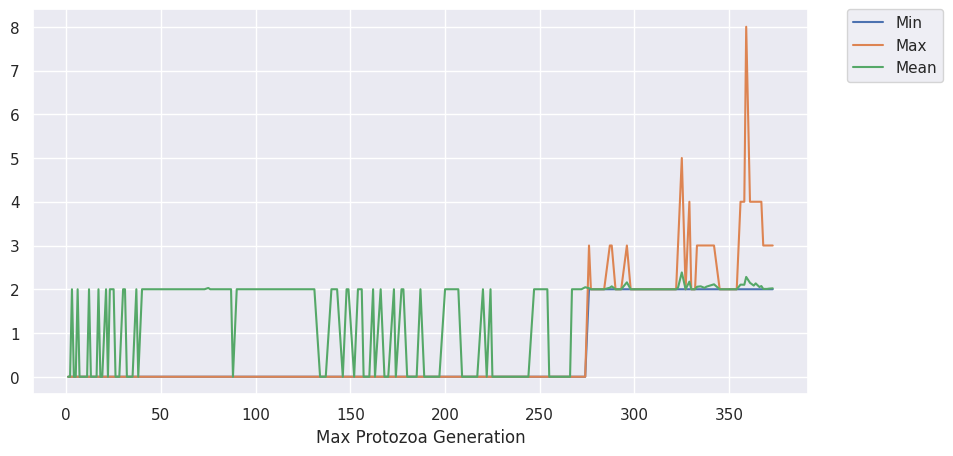

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
stat = 'Multicell Structure Size'
for suffix in ['Min', 'Max', 'Mean']:
    sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=f'{stat} {suffix}', ax=ax, label=suffix)

if stat in stat_type_strs and stat_type_strs[stat] != '':
    ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
else:
    ax.set_ylabel('')

# place legend outside of plot to the right
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Multicell Structure Size Count', ax=ax, label='Min')

In [ ]:
def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['frequency'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
    if time in stats
])

In [ ]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,frequency
0,-9223239949182548345,1,2023-03-05-16-52-35,1.000000,300,0.003333
1,3111382536755560872,1,2023-03-05-16-52-35,1.000000,300,0.003333
2,3108648323931458203,1,2023-03-05-16-52-35,1.000000,300,0.003333
3,3109380954978601831,1,2023-03-05-16-52-35,1.000000,300,0.003333
4,3109817975278749086,1,2023-03-05-16-52-35,1.000000,300,0.003333
...,...,...,...,...,...,...
1091,-584323143082095641,1,2023-03-07-08-42-18,317.946746,338,0.002959
1092,-636015739255438714,1,2023-03-07-08-42-18,317.946746,338,0.002959
1093,-650348322974186600,1,2023-03-07-08-42-18,317.946746,338,0.002959
1094,-719482957709621201,1,2023-03-07-08-42-18,317.946746,338,0.002959


In [ ]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(200))\
    .reset_index()
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-6688341974379245942,26944.000000,917.118021,14522.333333,0.251153
1,-8127724096715865005,21041.333333,917.118021,14522.333333,0.217985
2,9035812594871452235,21041.333333,917.118021,14522.333333,0.217985
3,2752484554098495426,47841.200000,2275.800988,19051.800000,0.188565
4,2955089098780069643,31629.583333,1553.190610,10265.583333,0.177775


In [ ]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='frequency')

In [ ]:
reaches_high_freq = high_var_genes_df_pivot.max() >  0.75
reaches_high_freq_sigs = reaches_high_freq.index[reaches_high_freq.values].values

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


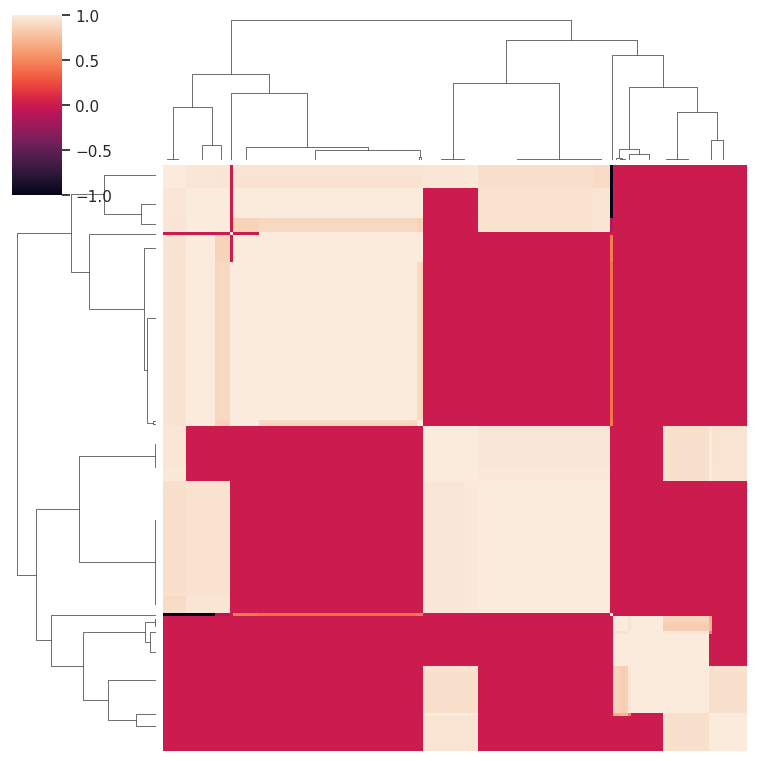

In [ ]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [ ]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.05 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters_ids = np.unique(idx)
clusters = {
    cluster_id: [
        signature for signature, cluster in signature_clusters.items()
        if cluster == cluster_id
    ]
    for cluster_id in clusters_ids
}
clusters_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

In [ ]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var frequency'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

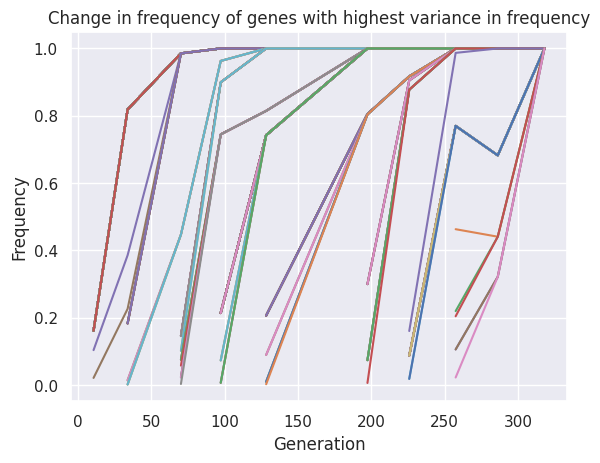

In [ ]:
plot_sigs = high_var_genes_df['signature'][high_var_genes_df['signature'].isin(reaches_high_freq_sigs)].unique()

for gene in plot_sigs:
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

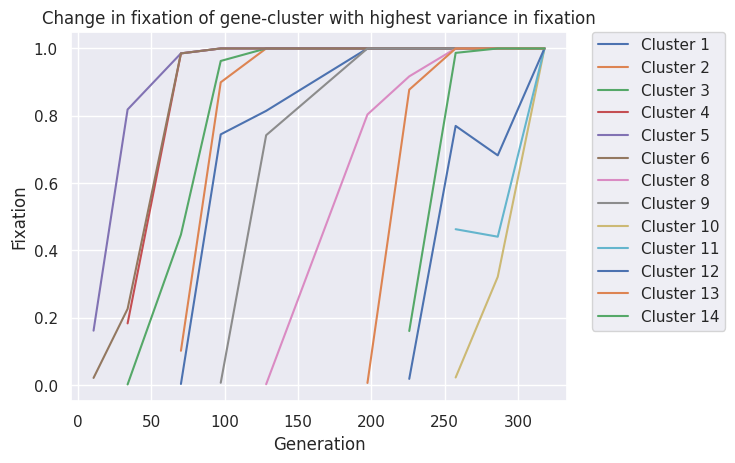

In [ ]:
for cluster_id, gene in cluster_prototypes.items():
    if gene not in plot_sigs:
        continue
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'], label=f'Cluster {cluster_id}')
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
# legend outside of plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
last_generation_time_stamp = max(genomes.keys(), key=get_datetime)
last_generation_time_stamp

last_generation_signatures = set([
    gene['signature']
    for genome in genomes[last_generation_time_stamp]
    for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
])

survived_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(last_generation_signatures)]
survived_genes_df.head()

,signature,count,time,generation,num_protozoa,frequency
287,-6612451231092552008,39,2023-03-05-19-46-15,10.566116,242,0.161157
288,-3399517936452547179,39,2023-03-05-19-46-15,10.566116,242,0.161157
289,-3457479064946847748,39,2023-03-05-19-46-15,10.566116,242,0.161157
290,5152801124620979710,39,2023-03-05-19-46-15,10.566116,242,0.161157
291,3838970862249397712,39,2023-03-05-19-46-15,10.566116,242,0.161157


In [ ]:
survived_variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
survived_variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,-6688341974379245942,26944.000000,917.118021,14522.333333,0.251153
1,-8127724096715865005,21041.333333,917.118021,14522.333333,0.217985
2,9035812594871452235,21041.333333,917.118021,14522.333333,0.217985
3,2752484554098495426,47841.200000,2275.800988,19051.800000,0.188565
4,2955089098780069643,31629.583333,1553.190610,10265.583333,0.177775


In [ ]:
survived_high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(survived_variance_df['signature'])]

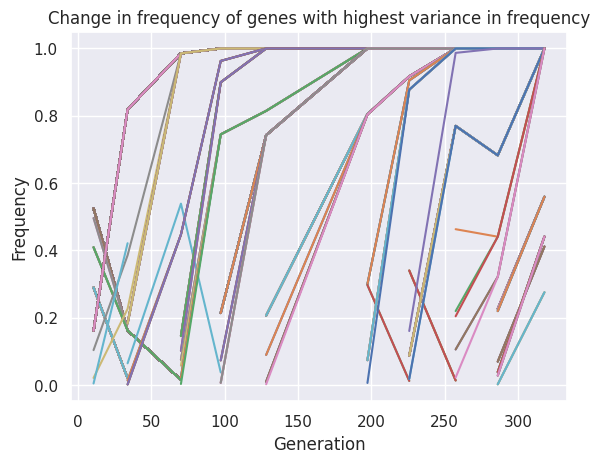

In [ ]:
for gene in survived_high_var_genes_df['signature'].unique():
    gene_ts = survived_high_var_genes_df[survived_high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

In [ ]:
variance_df['cluster id'] = variance_df['signature'].map(signature_clusters)
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency,cluster id
0,-6688341974379245942,26944.000000,917.118021,14522.333333,0.251153,10
1,-8127724096715865005,21041.333333,917.118021,14522.333333,0.217985,10
2,9035812594871452235,21041.333333,917.118021,14522.333333,0.217985,10
3,2752484554098495426,47841.200000,2275.800988,19051.800000,0.188565,13
4,2955089098780069643,31629.583333,1553.190610,10265.583333,0.177775,12


In [ ]:
variance_df.groupby('cluster id').var()

,signature,var count,var generation,var num_protozoa,var frequency
cluster id,,,,,
1,2.744527e+37,6.700502e+06,0.00000,0.000000e+00,0.000043
2,1.784336e+37,2.311480e+06,0.00000,0.000000e+00,0.000016
3,3.791767e+37,3.768802e+05,0.00000,0.000000e+00,0.000002
4,1.525146e+37,0.000000e+00,0.00000,0.000000e+00,0.000000
5,1.914300e+37,0.000000e+00,0.00000,0.000000e+00,0.000000
6,3.915051e+37,3.735870e+07,0.00000,0.000000e+00,0.000543
7,NaN,NaN,NaN,NaN,NaN
8,2.908444e+37,4.581443e+07,0.00000,0.000000e+00,0.000622
9,3.077843e+37,2.249605e+07,0.00000,0.000000e+00,0.000214
